In [1]:
# -*- coding: utf8

from label_shift.skwrapper import LabelShiftDetectorSKLearn

from statsmodels.distributions.empirical_distribution import ECDF

from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection
from sklearn import neural_network
from sklearn import linear_model
from sklearn import svm

import matplotlib.pyplot as plt
import numpy as np

plt.ion()

In [2]:
import warnings
warnings.filterwarnings('ignore')

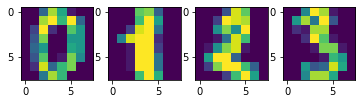

In [3]:
digits = datasets.load_digits()

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.imshow(image)

In [4]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

X = data
y = digits.target
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=0.2)

In [5]:
print(X_train.shape)
print(X_test.shape)

(1437, 64)
(360, 64)


In [6]:
ko_classes = {1, 2, 3, 4, 6, 7, 8, 9}
ko_prob = 0.9

keep = np.ones(len(y_train), dtype='bool')
for i in range(len(y_train)):
    if y_train[i] in ko_classes and np.random.rand() < ko_prob:
        keep[i] = False

In [7]:
print(keep.sum() / keep.shape[0])

0.2894919972164231


In [8]:
X_train = X_train[keep]
y_train = y_train[keep]

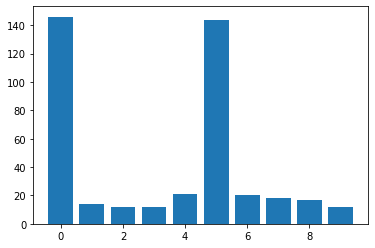

In [9]:
labels, count = np.unique(y_train, return_counts=True)
plt.bar(labels, count);

In [10]:
# base = neural_network.MLPClassifier(hidden_layer_sizes=(128, 128))
# base = svm.SVC(gamma=0.001)
base = linear_model.LogisticRegressionCV()
classifier = LabelShiftDetectorSKLearn(base)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      1.00      0.74        32
           1       0.88      0.46      0.60        46
           2       0.94      0.80      0.87        41
           3       1.00      0.79      0.89        34
           4       1.00      0.96      0.98        25
           5       0.62      1.00      0.77        38
           6       0.75      0.97      0.85        37
           7       0.95      0.91      0.93        43
           8       0.51      0.64      0.57        28
           9       0.50      0.14      0.22        36

    accuracy                           0.76       360
   macro avg       0.77      0.77      0.74       360
weighted avg       0.78      0.76      0.74       360



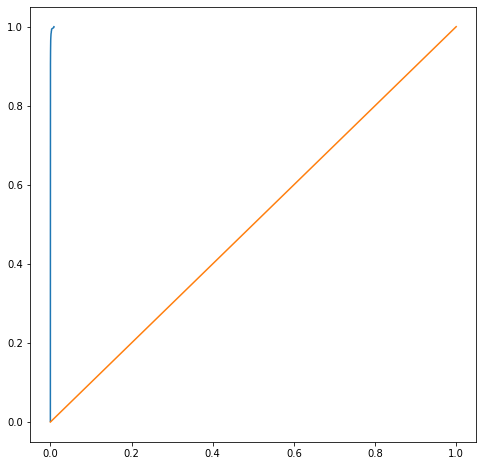

In [11]:
plt.figure(figsize=(8, 8))
p, pvals = classifier.label_shift_detector(X_test, return_bootstrap=True)
ecdf = ECDF(pvals)
plt.plot(ecdf.x, ecdf.y)
plt.plot(ecdf.y, ecdf.y)

In [12]:
p, nrm, kld = classifier.label_shift_detector(X_test, y_test)
print(p, nrm, kld)

1.5755259056400494e-05 67.03379854533202 1.8120352283989751


In [13]:
y_pred = classifier.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      1.00      0.74        32
           1       0.88      0.46      0.60        46
           2       0.94      0.80      0.87        41
           3       1.00      0.79      0.89        34
           4       1.00      0.96      0.98        25
           5       0.62      1.00      0.77        38
           6       0.75      0.97      0.85        37
           7       0.95      0.91      0.93        43
           8       0.51      0.64      0.57        28
           9       0.50      0.14      0.22        36

    accuracy                           0.76       360
   macro avg       0.77      0.77      0.74       360
weighted avg       0.78      0.76      0.74       360



In [14]:
weights = classifier.wt_est_[:, 0].copy()
weights = weights / weights.sum()
class_weights = {}
for k in range(len(weights)):
    class_weights[k] = weights[k]

new_classifier = linear_model.LogisticRegressionCV(class_weight=class_weights)
new_classifier.fit(X_train, y_train)
y_pred = new_classifier.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96        32
           1       0.94      0.63      0.75        46
           2       0.98      0.98      0.98        41
           3       1.00      0.74      0.85        34
           4       0.89      0.96      0.92        25
           5       0.64      1.00      0.78        38
           6       0.82      0.97      0.89        37
           7       0.98      0.93      0.95        43
           8       0.73      0.68      0.70        28
           9       0.94      0.81      0.87        36

    accuracy                           0.87       360
   macro avg       0.88      0.87      0.86       360
weighted avg       0.89      0.87      0.87       360

